               Open          High           Low         Close
count    398.000000    398.000000    398.000000    398.000000
mean   23970.764573  24366.717839  23591.012060  23990.299497
std     4626.221037   4677.803979   4579.110022   4624.840283
min    16129.400000  16299.200000  15498.300000  16129.200000
25%    19682.175000  20056.400000  19244.000000  19682.100000
50%    25692.550000  25990.400000  24921.100000  25755.900000
75%    27890.575000  28282.075000  27263.950000  27890.475000
max    31243.000000  31822.100000  30829.800000  31243.000000


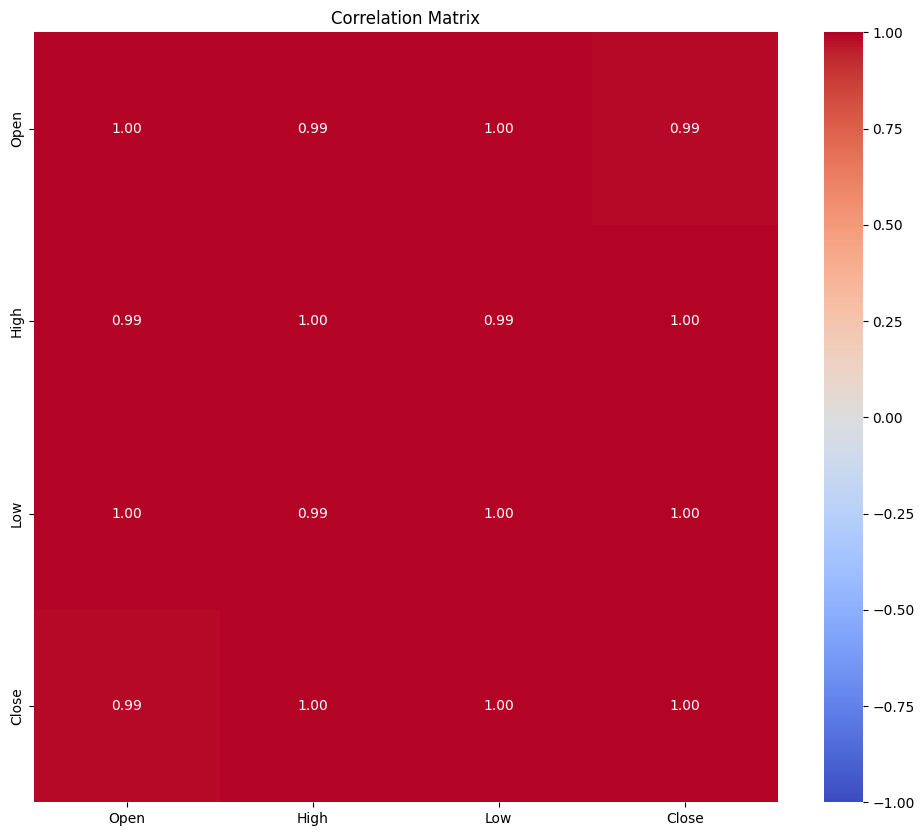

[LightGBM] [Info] Number of positive: 157, number of negative: 161
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 318, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493711 -> initscore=-0.025159
[LightGBM] [Info] Start training from score -0.025159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Read the CSV file
btc_data = pd.read_csv("data-BTC-USDT-from-2022-09-01-to-2023-10-05.csv")

# Convert 'date' to datetime
# btc_data['date'] = pd.to_datetime(btc_data['date'])

# Set 'date' as the index
btc_data.set_index('Timestamp', inplace=True)

# Sort the data by date
btc_data.sort_index(inplace=True)

# Data Cleaning: Drop rows with missing 'Close' values
btc_data = btc_data.dropna(subset=['Close'])

# Exploratory Data Analysis: Descriptive Statistics
print(btc_data.describe())

# Exploratory Data Analysis: Visualization (e.g., Heatmap)
correlation_matrix = btc_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Feature Engineering: Calculate Technical Indicators
btc_data['ema_12'] = btc_data['Close'].ewm(span=12, adjust=False).mean()
btc_data['ema_26'] = btc_data['Close'].ewm(span=26, adjust=False).mean()
btc_data['macd'] = btc_data['ema_12'] - btc_data['ema_26']
btc_data['signal_line'] = btc_data['macd'].ewm(span=9, adjust=False).mean()
btc_data['macd_histogram'] = btc_data['macd'] - btc_data['signal_line']

# More Technical Indicators Here...

# Label Creation: Example - Price Direction
btc_data['price_direction'] = (btc_data['Close'].shift(-1) >= btc_data['Close']).astype(int)

# Handle Missing Values for Technical Indicators
technical_indicator_columns = ['ema_12', 'ema_26', 'macd', 'signal_line', 'macd_histogram']
btc_data[technical_indicator_columns] = btc_data[technical_indicator_columns].fillna(method='bfill')

# Drop rows with missing labels
btc_data = btc_data.dropna(subset=['price_direction'])

# Feature Selection
feature_columns = ['macd', 'signal_line', 'macd_histogram', 'ema_12', 'ema_26']
X = btc_data[feature_columns]
y = btc_data['price_direction']

# Data Splitting (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model Training: LightGBM for Price Direction Prediction
model_direction = lgb.LGBMClassifier()
model_direction.fit(X_train, y_train)

# Model Evaluation
y_pred_direction = model_direction.predict(X_test)
accuracy_direction = accuracy_score(y_test, y_pred_direction)
classification_report_direction = classification_report(y_test, y_pred_direction)

print("Accuracy:", accuracy_direction)
print("Classification Report:\n", classification_report_direction)
